# Stock Market Dataset (Simulated) — End-to-End ML Project (EDA → Modeling → Tuning → Ensembles → Neural Nets)

**Dataset:** random_stock_market_dataset.csv (Kaggle)

## Goals
We will build **two tasks** from the same dataset:

1) **Regression (Forecasting)**: Predict **next-day Close** using only information available up to day *t*
2) **Classification (Direction)**: Predict whether **next-day Close will go up** (1) or down (0)

## Why two tasks?
- Regression is natural for price forecasting.
- Classification is useful for “directional” trading-style ML (up vs down).

## Evaluation metrics
- Regression: MAE, RMSE, R²
- Classification: Accuracy, F1, ROC-AUC, Confusion Matrix

## Time-series rule (avoid leakage)
All features must be based on **past data only** (lags/rolling features) and the split must be **chronological**.

In [1]:
# Imports + Settings

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from dataclasses import dataclass

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.svm import SVR, SVC, LinearSVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.dummy import DummyRegressor, DummyClassifier

from sklearn.ensemble import VotingClassifier, StackingClassifier

import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

In [2]:
# Quick Verification of all the installed packages before we begin our project
import sys, numpy, pandas, sklearn
import matplotlib
print("Python:", sys.version)
print("NumPy:", numpy.__version__)
print("Pandas:", pandas.__version__)
print("sklearn:", sklearn.__version__)
print("matplotlib:", matplotlib.__version__)

try:
    import torch
    print("PyTorch:", torch.__version__)
except Exception as e:
    print("PyTorch import failed:", e)

try:
    import tensorflow as tf
    print("TensorFlow:", tf.__version__)
except Exception as e:
    print("TensorFlow import failed:", e)

Python: 3.13.0 (v3.13.0:60403a5409f, Oct  7 2024, 00:37:40) [Clang 15.0.0 (clang-1500.3.9.4)]
NumPy: 2.4.1
Pandas: 3.0.0
sklearn: 1.8.0
matplotlib: 3.10.8
PyTorch: 2.10.0
TensorFlow: 2.20.0


## 1) Load Data
- Read CSV
- Parse Date
- Sort chronologically
- Quick sanity checks

In [3]:
# 1) Load Data

DATA_PATH = "random_stock_market_dataset.csv"

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head())

Shape: (60, 6)


,Date,Open,High,Low,Close,Volume
0,2024-01-01,296.45,307.31,293.96,303.72,93133
1,2024-01-02,190.11,193.10,187.21,191.40,64993
2,2024-01-03,197.41,208.64,193.37,205.89,70326
3,2024-01-04,253.13,262.67,248.67,258.95,17358
4,2024-01-05,241.35,253.09,238.99,252.20,20847


In [5]:
# 1) Load Data (time-series safe)
DATA_PATH = "random_stock_market_dataset.csv"

df = pd.read_csv(DATA_PATH)

# Parse Date + sort (critical)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.sort_values("Date").reset_index(drop=True)

# Sanity checks
print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("Date range:", df["Date"].min(), "→", df["Date"].max())
display(df.head())
display(df.tail())

# Quick datatype view
display(df.dtypes)

Shape: (60, 6)
Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
Date range: 2024-01-01 00:00:00 → 2024-02-29 00:00:00


,Date,Open,High,Low,Close,Volume
0,2024-01-01,296.45,307.31,293.96,303.72,93133
1,2024-01-02,190.11,193.10,187.21,191.40,64993
2,2024-01-03,197.41,208.64,193.37,205.89,70326
3,2024-01-04,253.13,262.67,248.67,258.95,17358
4,2024-01-05,241.35,253.09,238.99,252.20,20847


,Date,Open,High,Low,Close,Volume
55,2024-02-25,170.55,181.13,167.39,178.58,47071
56,2024-02-26,187.88,195.26,186.36,193.36,115659
57,2024-02-27,355.67,375.14,353.60,370.56,62294
58,2024-02-28,289.90,298.27,289.06,298.01,108022
59,2024-02-29,120.34,131.84,116.30,129.95,64201


Date      datetime64[us]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
dtype: object

## 2) Quick Dataset Overview
- info(), describe()
- check duplicates
- check missing values

In [6]:
display(df.info())
display(df.describe(include="all").T)

dup_count = df.duplicated().sum()
print("Duplicates:", dup_count)

missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
display(pd.DataFrame({"missing": missing, "missing_%": missing_pct}))

<class 'pandas.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    60 non-null     datetime64[us]
 1   Open    60 non-null     float64       
 2   High    60 non-null     float64       
 3   Low     60 non-null     float64       
 4   Close   60 non-null     float64       
 5   Volume  60 non-null     int64         
dtypes: datetime64[us](1), float64(4), int64(1)
memory usage: 2.9 KB


None

,count,mean,min,25%,50%,75%,max,std
Date,60,2024-01-30 12:00:00,2024-01-01 00:00:00,2024-01-15 18:00:00,2024-01-30 12:00:00,2024-02-14 06:00:00,2024-02-29 00:00:00,NaN
Open,60.0,310.552,112.68,222.9575,303.24,396.15,492.79,108.859051
High,60.0,322.589833,123.78,238.2475,313.8,415.915,501.67,109.095813
Low,60.0,308.056833,109.43,220.0425,302.385,392.905,492.3,108.986426
Close,60.0,320.412667,121.27,237.2425,309.385,413.4625,500.42,109.157159
Volume,60.0,95405.516667,13193.0,48016.5,93850.5,130917.25,195189.0,54895.342146


Duplicates: 0


,missing,missing_%
Date,0,0.0
Open,0,0.0
High,0,0.0
Low,0,0.0
Close,0,0.0
Volume,0,0.0


## 3) EDA (Exploratory Data Analysis)

We’ll look at:
- price series (Open/High/Low/Close)
- volume
- relationships (correlations)
- target behavior (returns/direction)

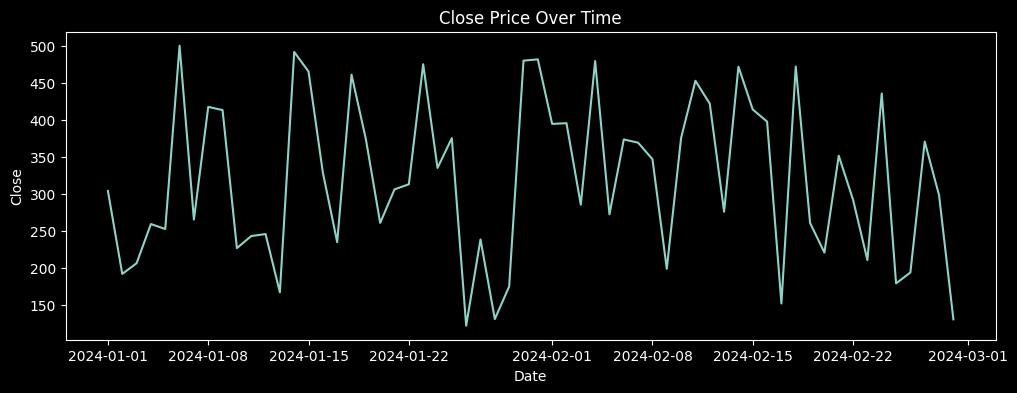

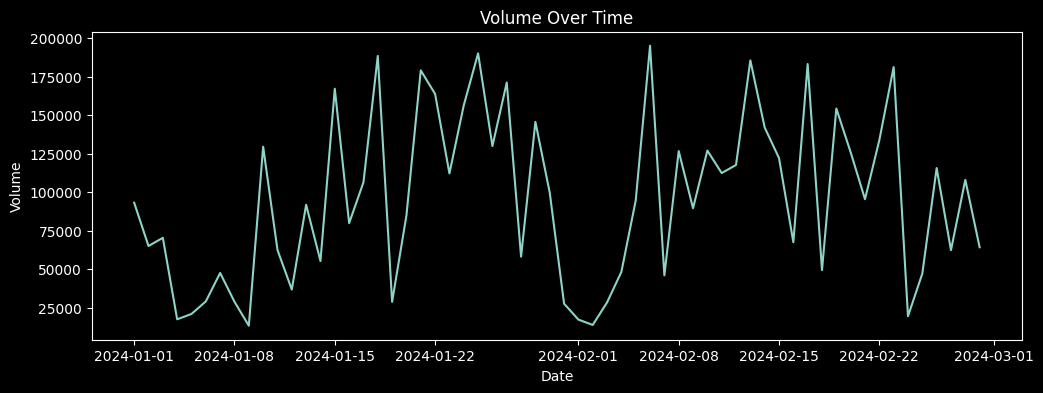

In [7]:
# 3) EDA

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df["Date"], df["Close"])
ax.set_title("Close Price Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Close")
plt.show()

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df["Date"], df["Volume"])
ax.set_title("Volume Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Volume")
plt.show()

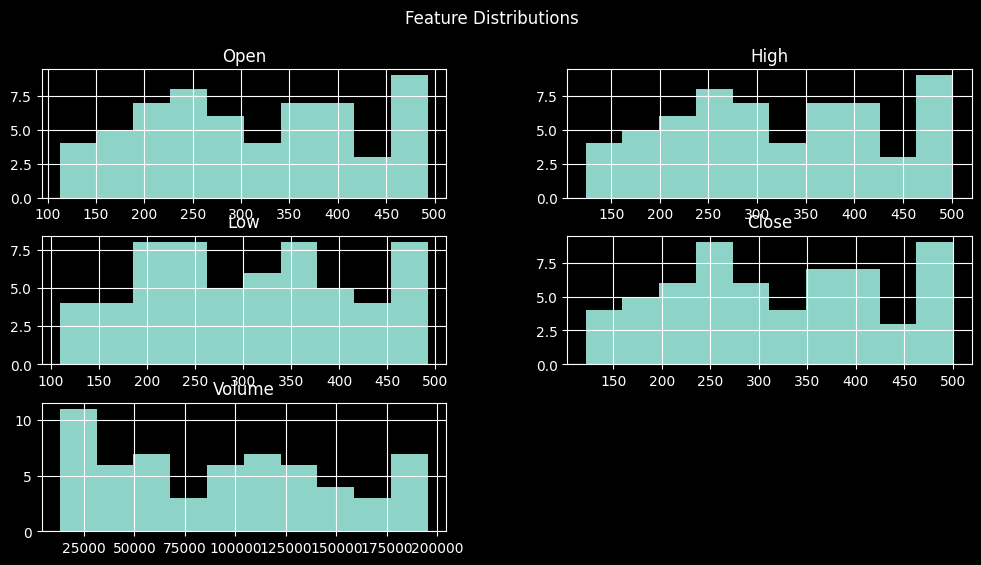

In [8]:
# Price distributions
num_cols = ["Open", "High", "Low", "Close", "Volume"]
df[num_cols].hist(figsize=(12, 6))
plt.suptitle("Feature Distributions")
plt.show()

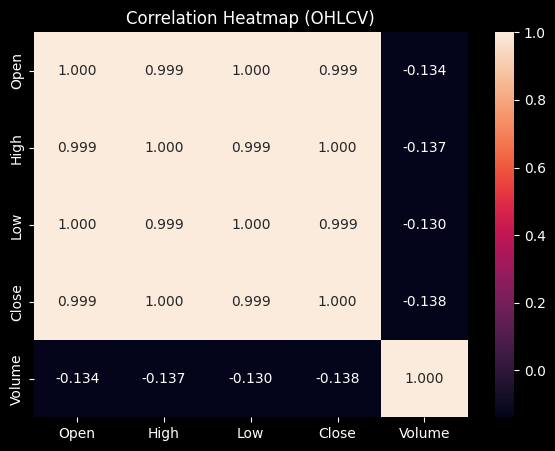

In [11]:
# Correlation heatmap (simple pandas view; no seaborn)num_cols = ["Open", "High", "Low", "Close", "Volume"]
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = ["Open", "High", "Low", "Close", "Volume"]
corr = df[num_cols].corr(numeric_only=True)

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, fmt=".3f")
plt.title("Correlation Heatmap (OHLCV)")
plt.show()

## EDA — Explanation of All Graphs and Diagrams

This EDA section contains 4 main visualizations:

1) **Close Price Over Time (line plot)**
2) **Volume Over Time (line plot)**
3) **Feature Distributions (histograms for Open/High/Low/Close/Volume)**
4) **Correlation Heatmap (OHLCV)**

The dataset is simulated and relatively small (60 rows), so our goal here is to understand how to *read* these plots and what they imply for modeling.

---

# 1) Close Price Over Time (Line Plot)

### What you are seeing
- **X-axis:** Date (chronological order)
- **Y-axis:** Close price
- Each point is the **closing price** on that day. The line simply connects them to show how the close changes over time.

### What this plot helps you check
✅ **Trend:** Is the price generally going up, down, or sideways?
✅ **Volatility:** Do prices jump a lot day-to-day (big spikes/drops) or move smoothly?
✅ **Outliers:** Any extreme days that look unusually high/low compared to others?
✅ **Stationarity hint:** If the level is drifting a lot, raw price can be harder to model than returns.

### What your plot suggests
- Your close series looks **highly jumpy** and **not smoothly trending**.
- That is common in simulated/random-like series (and also real markets in shorter windows).

### Modeling implication
If the data is jumpy, often it’s easier to model:
- **returns**, **direction**, **rolling averages**, **rolling volatility**, etc.,
instead of the raw Close.

---

# 2) Volume Over Time (Line Plot)

### What you are seeing
- **X-axis:** Date
- **Y-axis:** Volume (number of shares traded that day in this simulated data)

### What this plot helps you check
✅ **Spikes:** Are there days with unusually high volume?
✅ **Regime changes:** Does volume stay low for a while then become high?
✅ **Relationship idea:** Do volume spikes happen on big price moves?

### What your plot suggests
- Volume fluctuates strongly day-to-day (spiky).
- This means the dataset includes **very different activity levels** across days.

### Modeling implication
Volume can be useful as a signal for:
- stronger price moves
- volatility changes
But volume does *not* guarantee direction (up/down). It often correlates more with *movement magnitude* than with *sign*.

---

# 3) Feature Distributions (Histograms)

You plotted histograms for:
- Open, High, Low, Close, Volume

### How to read a histogram
- **X-axis:** the value range (bins)
- **Y-axis:** how many days fall into each bin (frequency)

### What histograms help you check
✅ **Typical range:** Where most values lie
✅ **Skewness:** is the distribution symmetric or heavily one-sided?
✅ **Outliers:** rare extreme values show up in far-left/far-right bins
✅ **Scaling needs:** volume is usually much larger than prices → it can dominate models unless scaled

### What your histograms suggest
- Open/High/Low/Close are spread across a wide range (~100 to ~500).
- Volume also spans a wide range and is on a completely different scale than prices.

### Modeling implication
- For most ML models (Logistic Regression, SVM, Neural Nets), you should use **feature scaling**:
  - StandardScaler or RobustScaler in a pipeline
- Tree models (Decision Tree, Random Forest) are less sensitive to scaling, but scaling still won’t hurt.

---

# 4) Correlation Heatmap (OHLCV)

This plot visualizes the **correlation matrix** between numeric columns.

### What correlation means (important)
Correlation is a number between -1 and +1:

- **+1.0** → two variables move together perfectly
- **0.0** → no consistent linear relationship
- **-1.0** → move in opposite directions perfectly

### What each square means
Each cell shows correlation between:
- row feature (left label) and column feature (bottom label)

Example:
- the square at (Open, Close) is corr(Open, Close)

### Why the diagonal is 1.000
Because corr(Open, Open) = 1 by definition.
Every feature is perfectly correlated with itself.

---

## What your heatmap is telling you

### (A) Open, High, Low, Close are ~0.999 correlated
This is why you see that big bright block of ~1.000 values.

**Meaning:**
These price features contain almost the same information.

**Reason:**
High and Low are derived from the day’s price range, and Open/Close are within that range.
So these variables are naturally linked.

✅ This is normal in OHLC datasets.

**Modeling implication:**
- There is strong **multicollinearity** among price features.
- Many models don’t need all of them at once.
- In linear models, multicollinearity can make coefficients unstable (not necessarily accuracy, but interpretation).
- In tree models, it often results in redundant splits.

### (B) Volume has weak negative correlation with prices (~ -0.13)
Values like -0.134, -0.137, -0.138 are small.

**Meaning:**
When price is higher, volume tends to be slightly lower *on average* in this dataset, but the effect is weak.

**How weak?**
A common rule:
- |corr| < 0.2 → weak
- 0.2–0.5 → moderate
- > 0.5 → strong

So volume is basically **mostly independent** of price level here.

---

# Summary of What We Learned from EDA

✅ Data is clean (no missing values, no duplicates).
✅ Prices (Open/High/Low/Close) move together strongly.
✅ Volume varies a lot and is only weakly related to price level.
✅ The series is noisy (short + simulated), so we should rely on:
- lag features
- rolling averages
- rolling volatility
- returns and direction targets
- time-series splits to avoid leakage

Next step: **Target creation + leakage-safe feature engineering (lags/rolling)**.

## Outliers & Box Plots

Even if there are no missing values, **outliers** can heavily affect many ML models (especially regression and linear models).

We will:
1. Visualize potential outliers using **box plots**
2. Quantify outliers using the **IQR rule**
3. (Optional) Apply outlier handling strategies later (clipping/winsorizing/robust scaling)

**Important:** In finance-style data, outliers are not always “bad” — they can represent real shocks or high-volatility days.
So we usually **detect and understand** them before removing anything.

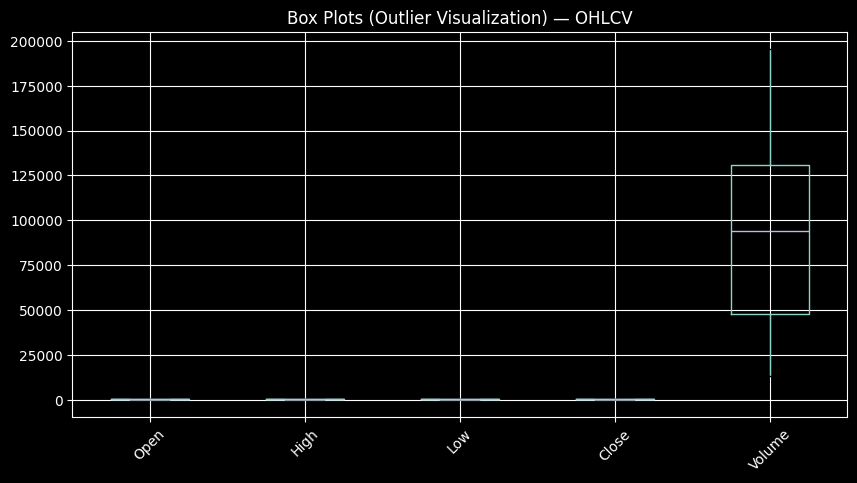

In [13]:
# Box plots for numeric columns (OHLCV)
import matplotlib.pyplot as plt

num_cols = ["Open", "High", "Low", "Close", "Volume"]

plt.figure(figsize=(10,5))
df[num_cols].boxplot()
plt.title("Box Plots (Outlier Visualization) — OHLCV")
plt.xticks(rotation=45)
plt.show()

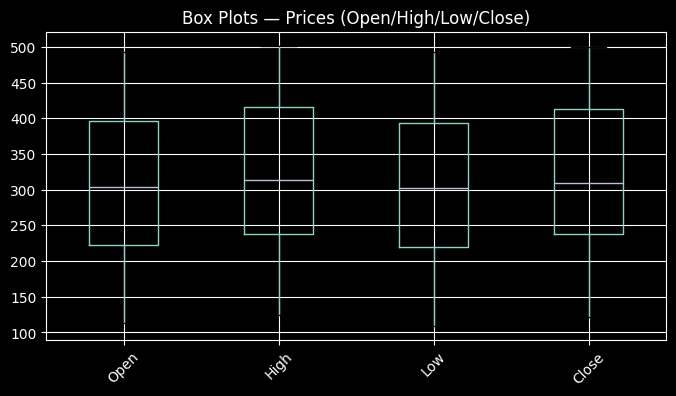

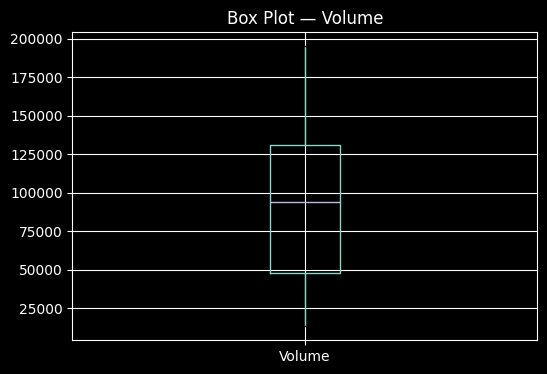

In [14]:
# Box plots (separate: prices vs volume) - clearer because scales differ
price_cols = ["Open", "High", "Low", "Close"]

plt.figure(figsize=(8,4))
df[price_cols].boxplot()
plt.title("Box Plots — Prices (Open/High/Low/Close)")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(6,4))
df[["Volume"]].boxplot()
plt.title("Box Plot — Volume")
plt.show()

## Quantifying Outliers with the IQR Rule

**IQR (Interquartile Range)**:
- Q1 = 25th percentile
- Q3 = 75th percentile
- IQR = Q3 - Q1

**Outlier rule (classic):**
- lower bound = Q1 - 1.5 * IQR
- upper bound = Q3 + 1.5 * IQR

Any values outside these bounds are flagged as outliers.

We will compute outlier counts per feature.

In [15]:
# IQR outlier counts
import pandas as pd

def iqr_outlier_summary(df_in: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    rows = []
    for c in cols:
        q1 = df_in[c].quantile(0.25)
        q3 = df_in[c].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        outlier_mask = (df_in[c] < lower) | (df_in[c] > upper)
        rows.append({
            "feature": c,
            "Q1": q1,
            "Q3": q3,
            "IQR": iqr,
            "lower_bound": lower,
            "upper_bound": upper,
            "outlier_count": int(outlier_mask.sum()),
            "outlier_%": float(outlier_mask.mean() * 100),
            "min": float(df_in[c].min()),
            "max": float(df_in[c].max())
        })
    return pd.DataFrame(rows).sort_values("outlier_count", ascending=False)

outlier_report = iqr_outlier_summary(df, num_cols)
display(outlier_report)

,feature,Q1,Q3,IQR,lower_bound,upper_bound,outlier_count,outlier_%,min,max
0,Open,222.9575,396.1500,173.1925,-36.83125,655.93875,0,0.0,112.68,492.79
1,High,238.2475,415.9150,177.6675,-28.25375,682.41625,0,0.0,123.78,501.67
2,Low,220.0425,392.9050,172.8625,-39.25125,652.19875,0,0.0,109.43,492.30
3,Close,237.2425,413.4625,176.2200,-27.08750,677.79250,0,0.0,121.27,500.42
4,Volume,48016.5000,130917.2500,82900.7500,-76334.62500,255268.37500,0,0.0,13193.00,195189.00


In [16]:
# Show the outlier rows for any feature you want (example: Volume)
feature = "Volume"

q1 = df[feature].quantile(0.25)
q3 = df[feature].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

outliers = df[(df[feature] < lower) | (df[feature] > upper)].copy()

print(f"{feature} outliers: {len(outliers)}")
display(outliers[["Date", "Open", "High", "Low", "Close", "Volume"]].sort_values(feature))

Volume outliers: 0


,Date,Open,High,Low,Close,Volume


## What We Do With Outliers (Decision)

We do **not** automatically delete outliers.

Typical options:
1. **Keep** them (common for market spikes)
2. **Cap/Winsorize** (clip extreme values to bounds)
3. **Transform** (e.g., log(Volume))
4. Use **robust models/scalers** (RobustScaler, tree models)

Because this is a small simulated dataset (60 rows), deleting outliers can remove too much data.
So by default, we will **keep them**, and later consider:
- `log1p(Volume)`
- `RobustScaler` in pipelines

<Figure size 1000x400 with 0 Axes>

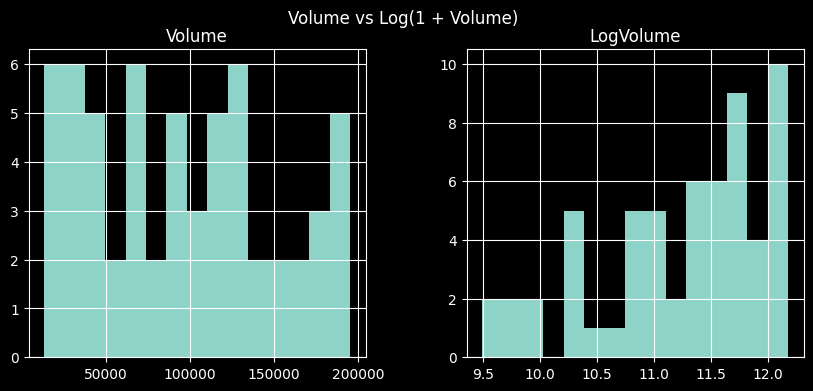

In [17]:
# log-transform Volume (often helpful)
df_eda2 = df.copy()
df_eda2["LogVolume"] = np.log1p(df_eda2["Volume"])

plt.figure(figsize=(10,4))
df_eda2[["Volume", "LogVolume"]].hist(bins=15, figsize=(10,4))
plt.suptitle("Volume vs Log(1 + Volume)")
plt.show()

## Outliers — Conclusion

- Using **box plots**, we checked for extreme values in **Open, High, Low, Close, and Volume**.
- A combined OHLCV box plot is dominated by **Volume’s larger numeric scale**, so we also inspected **prices separately** and **Volume separately**.
- Using the **IQR rule (1.5 × IQR)**, **no values were flagged as outliers** in any feature (outlier_count = 0 for all columns).
- Therefore, we **do not remove or cap any values** at this stage.

**Modeling note:** Even without IQR outliers, **Volume has a much larger scale** and may be skewed.
To improve model stability, we may:
- use `log1p(Volume)` as an engineered feature, and/or
- use scaling inside pipelines (e.g., `StandardScaler` / `RobustScaler`) for linear models.

## 4) Create Targets (Regression + Classification)

We create:
- `Close_next` = Close shifted by -1 (tomorrow’s close)
- `Direction_next` = 1 if Close_next > Close else 0

Then we must create features that use only *past* info (lags, rolling stats).

In [18]:
# 4) Targets

df["Close_next"] = df["Close"].shift(-1)
df["Direction_next"] = (df["Close_next"] > df["Close"]).astype(int)

# Drop last row (target becomes NaN there)
df = df.dropna(subset=["Close_next"]).reset_index(drop=True)

display(df[["Date", "Close", "Close_next", "Direction_next"]].head())

,Date,Close,Close_next,Direction_next
0,2024-01-01,303.72,191.40,0
1,2024-01-02,191.40,205.89,1
2,2024-01-03,205.89,258.95,1
3,2024-01-04,258.95,252.20,0
4,2024-01-05,252.20,500.42,1


## Targets — What we are predicting (No Leakage)

We create **two prediction tasks** from the same time series:

1) **Regression:** Predict `Close_next` (tomorrow's close price).
2) **Classification:** Predict `Direction_next` where:
   - `1` = tomorrow’s close is higher than today’s close
   - `0` = tomorrow’s close is lower or equal to today’s close

**Important (time-series rule):**
All model features must be built using **only information available up to day t**.
That means we can use today's OHLCV and **past lags/rolling stats**, but we must NOT use:
- `Close_next`
- any rolling/shift that accidentally uses future values

In [20]:
# --- Sanity checks for targets ---
print("Rows after dropping last NaN target:", len(df))
print(df[["Date", "Close", "Close_next", "Direction_next"]].tail(5))

# Direction balance (important for classification baseline)
dir_counts = df["Direction_next"].value_counts(dropna=False)
print("\nDirection_next counts:")
print(dir_counts)
print("\nDirection_next %:")
print((dir_counts / len(df) * 100).round(2))

Rows after dropping last NaN target: 59
         Date   Close  Close_next  Direction_next
54 2024-02-24  435.79      178.58               0
55 2024-02-25  178.58      193.36               1
56 2024-02-26  193.36      370.56               1
57 2024-02-27  370.56      298.01               0
58 2024-02-28  298.01      129.95               0

Direction_next counts:
Direction_next
0    32
1    27
Name: count, dtype: int64

Direction_next %:
Direction_next
0    54.24
1    45.76
Name: count, dtype: float64


## 5) Feature Engineering (Leakage-Safe)

We’ll build:
- Lag features: Close_lag1, Return_lag1, Volume_lag1
- Rolling features: rolling mean/std of returns (using past only)
- Candle features:
  - range = High - Low
  - body = Close - Open
  - gap = Open - Close_lag1
- Date features: dayofweek, month

All rolling features use `.shift(1)` before rolling, to ensure we never use today’s close to predict tomorrow’s close incorrectly.

In [19]:
# 5) Feature Engineering
df_feat = df.copy()

# Basic return
df_feat["Return"] = df_feat["Close"].pct_change()

# Lags (past info)
df_feat["Close_lag1"] = df_feat["Close"].shift(1)
df_feat["Return_lag1"] = df_feat["Return"].shift(1)
df_feat["Volume_lag1"] = df_feat["Volume"].shift(1)

# Candle features (today uses today's open/high/low/close, allowed because prediction is for tomorrow)
df_feat["Range_HL"] = df_feat["High"] - df_feat["Low"]
df_feat["Body_CO"] = df_feat["Close"] - df_feat["Open"]
df_feat["Body_abs"] = (df_feat["Close"] - df_feat["Open"]).abs()

# Gap feature must use only past close for gap
df_feat["Gap_Open_vs_Close_lag1"] = df_feat["Open"] - df_feat["Close_lag1"]

# Rolling stats on returns: use shift(1) to ensure past-only
ret_past = df_feat["Return"].shift(1)

for w in [3, 5, 10]:
    df_feat[f"Ret_mean_{w}"] = ret_past.rolling(w).mean()
    df_feat[f"Ret_std_{w}"] = ret_past.rolling(w).std()

# Rolling volume stats (past-only)
vol_past = df_feat["Volume"].shift(1)
for w in [3, 5, 10]:
    df_feat[f"Vol_mean_{w}"] = vol_past.rolling(w).mean()
    df_feat[f"Vol_std_{w}"] = vol_past.rolling(w).std()

# Date features
df_feat["dayofweek"] = df_feat["Date"].dt.dayofweek
df_feat["month"] = df_feat["Date"].dt.month

# Drop rows where lags/rolling create NaNs
df_feat = df_feat.dropna().reset_index(drop=True)

print("After feature engineering:", df_feat.shape)
display(df_feat.head())

After feature engineering: (48, 30)


,Date,Open,High,Low,Close,Volume,Close_next,Direction_next,Return,Close_lag1,Return_lag1,Volume_lag1,Range_HL,Body_CO,Body_abs,Gap_Open_vs_Close_lag1,Ret_mean_3,Ret_std_3,Ret_mean_5,Ret_std_5,Ret_mean_10,Ret_std_10,Vol_mean_3,Vol_std_3,Vol_mean_5,Vol_std_5,Vol_mean_10,Vol_std_10,dayofweek,month
0,2024-01-12,231.07,246.40,229.38,245.42,36696,166.49,0,0.011249,242.69,0.072189,62443.0,17.02,14.35,14.35,-11.62,-0.130158,0.282016,-0.056967,0.432177,0.063692,0.459594,68400.333333,58414.278745,56289.6,44998.904151,48397.2,35380.542455,4,1
1,2024-01-13,155.92,166.99,153.19,166.49,91831,491.99,1,-0.321612,245.42,0.011249,36696.0,13.80,10.57,10.57,-89.50,-0.122952,0.286842,0.039396,0.365469,0.101798,0.434785,76234.666667,47946.014874,54132.6,45778.433736,45567.5,35035.649372,5,1
2,2024-01-14,481.91,492.40,477.12,491.99,55243,465.41,0,1.955072,166.49,-0.321612,91831.0,15.28,10.08,10.08,315.42,-0.079391,0.211971,-0.140168,0.231957,0.062067,0.455113,63656.666667,27587.529725,66745.6,45729.984975,47718.0,37310.338380,6,1
3,2024-01-15,455.69,469.25,451.11,465.41,167233,328.56,0,-0.054025,491.99,1.955072,55243.0,18.14,9.72,9.72,-36.30,0.548236,1.229671,0.252921,0.976704,0.231803,0.754339,61256.666667,28055.127808,75155.6,36317.056747,51506.5,35776.964738,0,1
4,2024-01-16,314.61,329.61,311.08,328.56,79832,234.46,0,-0.294042,465.41,-0.054025,167233.0,18.53,13.95,13.95,-150.80,0.526478,1.244412,0.332575,0.919371,0.229007,0.755452,104769.000000,57105.025243,82689.2,51258.666537,66145.1,49249.537634,1,1


## 6) Missing Values + Outliers Handling (Generalized)

Even if this dataset is clean, we implement realistic handling:
- Missing: impute with median
- Outliers: optional clipping based on quantiles

For finance-like features, clipping extreme tails can stabilize models.

In [21]:
# 6) Optional outlier clipping

def clip_outliers_quantile(df_in: pd.DataFrame, cols, lower_q=0.01, upper_q=0.99):
    df_out = df_in.copy()
    for c in cols:
        lo = df_out[c].quantile(lower_q)
        hi = df_out[c].quantile(upper_q)
        df_out[c] = df_out[c].clip(lo, hi)
    return df_out

feature_cols = [
    # raw
    "Open", "High", "Low", "Close", "Volume",
    # engineered
    "Close_lag1", "Return_lag1", "Volume_lag1",
    "Range_HL", "Body_CO", "Body_abs", "Gap_Open_vs_Close_lag1",
    "Ret_mean_3", "Ret_std_3", "Ret_mean_5", "Ret_std_5", "Ret_mean_10", "Ret_std_10",
    "Vol_mean_3", "Vol_std_3", "Vol_mean_5", "Vol_std_5", "Vol_mean_10", "Vol_std_10",
    "dayofweek", "month"
]

df_model = df_feat.copy()

# Clip numeric features (optional; comment out if you don't want it)
df_model = clip_outliers_quantile(df_model, feature_cols, 0.01, 0.99)

display(df_model[feature_cols].describe().T.head(10))

,count,mean,std,min,25%,50%,75%,max
Open,48.0,319.387804,108.790434,113.375600,229.165000,328.87000,408.83500,476.129000
High,48.0,331.711979,108.400832,128.564600,244.485000,343.52500,417.87250,489.260400
Low,48.0,316.982860,108.796541,110.558000,227.075000,326.51000,406.08750,472.039300
Close,48.0,329.518860,108.429236,125.509400,243.607500,340.86000,416.01000,487.275900
Volume,48.0,105881.578542,54080.597734,15338.080000,57379.000000,110095.00000,147854.00000,192851.690000
Close_lag1,48.0,328.366360,109.063416,125.509400,241.560000,340.86000,416.01000,487.275900
Return_lag1,48.0,0.154223,0.641529,-0.649876,-0.288311,-0.02566,0.40926,2.042656
Volume_lag1,48.0,104932.016042,54441.158554,15338.080000,57379.000000,109282.00000,147854.00000,192851.690000
Range_HL,48.0,14.610150,4.590662,7.482300,10.857500,13.97000,18.38750,24.374900
Body_CO,48.0,10.032944,4.335808,3.224700,6.520000,9.24000,14.37500,17.456600


## Conclusion — Missing Values & Outliers
	•	After feature engineering (lags + rolling stats), early rows naturally became NaN. We removed these rows using dropna(), leaving a clean modeling dataset.
	•	Using the IQR rule (1.5×IQR), no features were flagged as outliers (outlier_count = 0 across OHLCV).
	•	Even when IQR finds no outliers, finance-like data can still have extreme tails that destabilize some models.
Therefore, we implement optional quantile clipping (1%–99%) to reduce tail impact and improve training stability.
	•	Decision: We keep clipping optional and will compare model performance with vs without clipping during training.

## 7) Prepare Train / Validation / Test Splits (Chronological)

We split by time (no shuffle):
- Train: first 70%
- Val: next 15%
- Test: last 15%

We also define TimeSeriesSplit for cross-validation.

In [22]:
# 7) Chronological split

n = len(df_model)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

train_df = df_model.iloc[:train_end].copy()
val_df   = df_model.iloc[train_end:val_end].copy()
test_df  = df_model.iloc[val_end:].copy()

print("Sizes:", len(train_df), len(val_df), len(test_df))
print("Date range train:", train_df["Date"].min(), "→", train_df["Date"].max())
print("Date range val  :", val_df["Date"].min(),   "→", val_df["Date"].max())
print("Date range test :", test_df["Date"].min(),  "→", test_df["Date"].max())

Sizes: 33 7 8
Date range train: 2024-01-12 00:00:00 → 2024-02-13 00:00:00
Date range val  : 2024-02-14 00:00:00 → 2024-02-20 00:00:00
Date range test : 2024-02-21 00:00:00 → 2024-02-28 00:00:00


In [23]:
# Define X/y for both tasks
X_train = train_df[feature_cols]
X_val   = val_df[feature_cols]
X_test  = test_df[feature_cols]

y_train_reg = train_df["Close_next"]
y_val_reg   = val_df["Close_next"]
y_test_reg  = test_df["Close_next"]

y_train_clf = train_df["Direction_next"]
y_val_clf   = val_df["Direction_next"]
y_test_clf  = test_df["Direction_next"]

## 8) Preprocessing Pipeline (Impute + Scale)

- Imputer: median
- Scaler: StandardScaler (needed for linear models + SVM + neural nets)
- Trees/forests don’t need scaling, but pipelines keep everything consistent.

We’ll create:
- `preprocess_scaled` for scale-sensitive models
- `preprocess_unscaled` for tree-based models (still imputes)

In [24]:
# Preprocessing pipelines

numeric_features = feature_cols

preprocess_scaled = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]), numeric_features)
    ],
    remainder="drop"
)

preprocess_unscaled = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
        ]), numeric_features)
    ],
    remainder="drop"
)

## Conclusion (Part 8: Preprocessing)
•	We created preprocessing pipelines to ensure consistent, leakage-safe data preparation.

•	preprocess_scaled: median imputation + StandardScaler (for scale-sensitive models like linear models, SVM, neural nets).

•	preprocess_unscaled: median imputation only (for tree-based models that do not need scaling).

•	Using sklearn Pipelines ensures imputers/scalers are fit only on the training set and applied to validation/test without leakage.

## 9) Baselines

### Regression baseline
- DummyRegressor (mean)
- Naive “last value” baseline: predict Close_next ≈ Close (random walk assumption)

### Classification baseline
- DummyClassifier (most_frequent)
- Direction baseline based on always “up” or always “down”

In [25]:
# Regression baselines

def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

# Dummy baseline: mean
dummy_reg = Pipeline(steps=[
    ("preprocess", preprocess_unscaled),
    ("model", DummyRegressor(strategy="mean"))
])
dummy_reg.fit(X_train, y_train_reg)
pred_dummy = dummy_reg.predict(X_val)
print("DummyReg (mean) on VAL:", regression_metrics(y_val_reg, pred_dummy))

# Naive random-walk baseline: predict next close = today's close
pred_naive = val_df["Close"].values  # same-day close as prediction for next-day close
print("Naive (Close_t) on VAL:", regression_metrics(y_val_reg, pred_naive))

DummyReg (mean) on VAL: {'MAE': 94.30454545454545, 'RMSE': np.float64(109.2014188549268), 'R2': -0.0322223007072604}
Naive (Close_t) on VAL: {'MAE': 146.38285714285715, 'RMSE': np.float64(181.64478782188368), 'R2': -1.8560286278570772}


In [26]:
# Classification baselines

dummy_clf = Pipeline(steps=[
    ("preprocess", preprocess_unscaled),
    ("model", DummyClassifier(strategy="most_frequent"))
])
dummy_clf.fit(X_train, y_train_clf)
pred_dummy_c = dummy_clf.predict(X_val)
acc = accuracy_score(y_val_clf, pred_dummy_c)
f1 = f1_score(y_val_clf, pred_dummy_c)
print("DummyClf (most_frequent) on VAL:", {"Accuracy": acc, "F1": f1})

always_up = np.ones_like(y_val_clf)
always_down = np.zeros_like(y_val_clf)
print("Always UP  :", {"Accuracy": accuracy_score(y_val_clf, always_up), "F1": f1_score(y_val_clf, always_up)})
print("Always DOWN:", {"Accuracy": accuracy_score(y_val_clf, always_down), "F1": f1_score(y_val_clf, always_down)})

DummyClf (most_frequent) on VAL: {'Accuracy': 0.7142857142857143, 'F1': 0.0}
Always UP  : {'Accuracy': 0.2857142857142857, 'F1': 0.4444444444444444}
Always DOWN: {'Accuracy': 0.7142857142857143, 'F1': 0.0}


## 10) Model Zoo (Advanced)

We evaluate multiple models consistently:

### Regression models
- LinearRegression, Ridge, Lasso, ElasticNet
- SVR (RBF)
- DecisionTreeRegressor
- RandomForestRegressor
- HistGradientBoostingRegressor

### Classification models
- Perceptron (from-scratch)
- Adaline (from-scratch)
- LogisticRegression
- LinearSVC, SVC (RBF)
- DecisionTreeClassifier
- RandomForestClassifier
- HistGradientBoostingClassifier

We will:
1) Train on Train
2) Evaluate on Val
3) Rank models by metric (RMSE for regression, F1/ROC-AUC for classification)

In [ ]:
# From-scratch Perceptron + Adaline (Raschka-style, sklearn-compatible)

from sklearn.base import BaseEstimator, ClassifierMixin

class PerceptronScratch(BaseEstimator, ClassifierMixin):
    """
    Binary perceptron: expects y in {0,1}. Internally uses {-1, +1}.
    """
    def __init__(self, eta=0.01, n_iter=50, random_state=42):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rng = np.random.RandomState(self.random_state)
        X = np.asarray(X)
        y = np.asarray(y).astype(int)
        y_ = np.where(y == 1, 1, -1)

        self.w_ = rng.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y_):
                update = self.eta * (target - self.predict_raw(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict_raw(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)

    def predict(self, X):
        raw = self.predict_raw(np.asarray(X))
        return np.where(raw == 1, 1, 0)


class AdalineScratch(BaseEstimator, ClassifierMixin):
    """
    Adaline (GD): expects y in {0,1}. Internally uses {-1, +1}.
    """
    def __init__(self, eta=0.0001, n_iter=100, random_state=42):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rng = np.random.RandomState(self.random_state)
        X = np.asarray(X)
        y = np.asarray(y).astype(int)
        y_ = np.where(y == 1, 1, -1)

        self.w_ = rng.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for _ in range(self.n_iter):
            net = self.net_input(X)
            output = net  # identity
            errors = (y_ - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).mean() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        net = self.net_input(np.asarray(X))
        raw = np.where(net >= 0.0, 1, -1)
        return np.where(raw == 1, 1, 0)

In [ ]:
# Regression model zoo

reg_models = {
    "LinearRegression": Pipeline([("preprocess", preprocess_scaled), ("model", LinearRegression())]),
    "Ridge":            Pipeline([("preprocess", preprocess_scaled), ("model", Ridge(random_state=RANDOM_STATE))]),
    "Lasso":            Pipeline([("preprocess", preprocess_scaled), ("model", Lasso(random_state=RANDOM_STATE))]),
    "ElasticNet":       Pipeline([("preprocess", preprocess_scaled), ("model", ElasticNet(random_state=RANDOM_STATE))]),
    "SVR_RBF":          Pipeline([("preprocess", preprocess_scaled), ("model", SVR(kernel="rbf"))]),
    "DecisionTree":     Pipeline([("preprocess", preprocess_unscaled), ("model", DecisionTreeRegressor(random_state=RANDOM_STATE))]),
    "RandomForest":     Pipeline([("preprocess", preprocess_unscaled), ("model", RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=300))]),
    "HGBRegressor":     Pipeline([("preprocess", preprocess_unscaled), ("model", HistGradientBoostingRegressor(random_state=RANDOM_STATE))]),
}

reg_results = []
for name, pipe in reg_models.items():
    pipe.fit(X_train, y_train_reg)
    pred = pipe.predict(X_val)
    m = regression_metrics(y_val_reg, pred)
    reg_results.append({"Model": name, **m})

reg_results_df = pd.DataFrame(reg_results).sort_values("RMSE")
display(reg_results_df)

In [ ]:
# Classification model zoo

clf_models = {
    "PerceptronScratch": Pipeline([("preprocess", preprocess_scaled), ("model", PerceptronScratch(eta=0.01, n_iter=50))]),
    "AdalineScratch":    Pipeline([("preprocess", preprocess_scaled), ("model", AdalineScratch(eta=0.0001, n_iter=200))]),
    "LogisticRegression":Pipeline([("preprocess", preprocess_scaled), ("model", LogisticRegression(max_iter=500, random_state=RANDOM_STATE))]),
    "LinearSVC":         Pipeline([("preprocess", preprocess_scaled), ("model", LinearSVC(random_state=RANDOM_STATE))]),
    "SVC_RBF":           Pipeline([("preprocess", preprocess_scaled), ("model", SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE))]),
    "DecisionTree":      Pipeline([("preprocess", preprocess_unscaled), ("model", DecisionTreeClassifier(random_state=RANDOM_STATE))]),
    "RandomForest":      Pipeline([("preprocess", preprocess_unscaled), ("model", RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=300))]),
    "HGBClassifier":     Pipeline([("preprocess", preprocess_unscaled), ("model", HistGradientBoostingClassifier(random_state=RANDOM_STATE))]),
}

clf_results = []
for name, pipe in clf_models.items():
    pipe.fit(X_train, y_train_clf)
    pred = pipe.predict(X_val)
    acc = accuracy_score(y_val_clf, pred)
    f1 = f1_score(y_val_clf, pred)
    clf_results.append({"Model": name, "Accuracy": acc, "F1": f1})

clf_results_df = pd.DataFrame(clf_results).sort_values("F1", ascending=False)
display(clf_results_df)

## 11) Time-Series Cross-Validation (K-fold but time-safe)

Instead of standard KFold, we use **TimeSeriesSplit**:
- each fold trains on the past
- validates on a future segment

This matches real forecasting constraints.

In [ ]:
# TimeSeriesSplit CV evaluation helpers

def ts_cv_regression(pipe, X, y, n_splits=5):
    # Ensure splits make sense for small datasets
    n_splits = min(n_splits, max(2, len(X)//5))
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = []
    for tr_idx, va_idx in tscv.split(X):
        Xtr, Xva = X.iloc[tr_idx], X.iloc[va_idx]
        ytr, yva = y.iloc[tr_idx], y.iloc[va_idx]
        pipe.fit(Xtr, ytr)
        pred = pipe.predict(Xva)
        rmse = np.sqrt(mean_squared_error(yva, pred))
        scores.append(rmse)
    return np.mean(scores), np.std(scores)

def ts_cv_classification(pipe, X, y, n_splits=5):
    n_splits = min(n_splits, max(2, len(X)//5))
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = []
    for tr_idx, va_idx in tscv.split(X):
        Xtr, Xva = X.iloc[tr_idx], X.iloc[va_idx]
        ytr, yva = y.iloc[tr_idx], y.iloc[va_idx]
        pipe.fit(Xtr, ytr)
        pred = pipe.predict(Xva)
        scores.append(f1_score(yva, pred))
    return np.mean(scores), np.std(scores)

# Example: evaluate top regression model by val RMSE
best_reg_name = reg_results_df.iloc[0]["Model"]
best_reg_pipe = reg_models[best_reg_name]
mean_rmse, std_rmse = ts_cv_regression(best_reg_pipe, pd.concat([X_train, X_val]), pd.concat([y_train_reg, y_val_reg]), n_splits=5)
print("Best REG model:", best_reg_name, "TimeSeriesCV RMSE:", mean_rmse, "+/-", std_rmse)

best_clf_name = clf_results_df.iloc[0]["Model"]
best_clf_pipe = clf_models[best_clf_name]
mean_f1, std_f1 = ts_cv_classification(best_clf_pipe, pd.concat([X_train, X_val]), pd.concat([y_train_clf, y_val_clf]), n_splits=5)
print("Best CLF model:", best_clf_name, "TimeSeriesCV F1:", mean_f1, "+/-", std_f1)

## 12) Hyperparameter Tuning (RandomizedSearchCV with TimeSeriesSplit)

We tune the top candidates only (otherwise it’s expensive and noisy).

### Regression tuning candidates
- Ridge / RandomForest / GradientBoosting / SVR

### Classification tuning candidates
- LogisticRegression / SVC / RandomForest / GradientBoosting

We use TimeSeriesSplit as the CV strategy.

In [ ]:
# Regression tuning example (Ridge + SVR + RF)

X_trainval = pd.concat([X_train, X_val])
y_trainval_reg = pd.concat([y_train_reg, y_val_reg])
y_trainval_clf = pd.concat([y_train_clf, y_val_clf])

tscv = TimeSeriesSplit(n_splits=min(5, max(2, len(X_trainval)//5)))

ridge_pipe = Pipeline([("preprocess", preprocess_scaled), ("model", Ridge(random_state=RANDOM_STATE))])
ridge_params = {
    "model__alpha": np.logspace(-4, 4, 50)
}

ridge_search = RandomizedSearchCV(
    ridge_pipe, ridge_params, n_iter=20, cv=tscv,
    scoring="neg_root_mean_squared_error", random_state=RANDOM_STATE
)
ridge_search.fit(X_trainval, y_trainval_reg)
print("Best Ridge:", ridge_search.best_params_, "Best CV RMSE:", -ridge_search.best_score_)

In [ ]:
svr_pipe = Pipeline([("preprocess", preprocess_scaled), ("model", SVR(kernel="rbf"))])
svr_params = {
    "model__C": np.logspace(-2, 3, 50),
    "model__gamma": np.logspace(-4, 1, 50),
    "model__epsilon": np.linspace(0.01, 1.0, 30)
}

svr_search = RandomizedSearchCV(
    svr_pipe, svr_params, n_iter=25, cv=tscv,
    scoring="neg_root_mean_squared_error", random_state=RANDOM_STATE
)
svr_search.fit(X_trainval, y_trainval_reg)
print("Best SVR:", svr_search.best_params_, "Best CV RMSE:", -svr_search.best_score_)

In [ ]:
rf_reg_pipe = Pipeline([("preprocess", preprocess_unscaled), ("model", RandomForestRegressor(random_state=RANDOM_STATE))])
rf_reg_params = {
    "model__n_estimators": [200, 400, 800],
    "model__max_depth": [None, 3, 5, 8, 12],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
}

rf_reg_search = RandomizedSearchCV(
    rf_reg_pipe, rf_reg_params, n_iter=20, cv=tscv,
    scoring="neg_root_mean_squared_error", random_state=RANDOM_STATE
)
rf_reg_search.fit(X_trainval, y_trainval_reg)
print("Best RF Reg:", rf_reg_search.best_params_, "Best CV RMSE:", -rf_reg_search.best_score_)

In [ ]:
# Classification tuning example (LogReg + SVC + RF)

logreg_pipe = Pipeline([("preprocess", preprocess_scaled), ("model", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))])
logreg_params = {
    "model__C": np.logspace(-3, 3, 50),
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"]
}

logreg_search = RandomizedSearchCV(
    logreg_pipe, logreg_params, n_iter=20, cv=tscv,
    scoring="f1", random_state=RANDOM_STATE
)
logreg_search.fit(X_trainval, y_trainval_clf)
print("Best LogReg:", logreg_search.best_params_, "Best CV F1:", logreg_search.best_score_)

In [ ]:
svc_pipe = Pipeline([("preprocess", preprocess_scaled), ("model", SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE))])
svc_params = {
    "model__C": np.logspace(-2, 3, 50),
    "model__gamma": np.logspace(-4, 1, 50),
}

svc_search = RandomizedSearchCV(
    svc_pipe, svc_params, n_iter=25, cv=tscv,
    scoring="f1", random_state=RANDOM_STATE
)
svc_search.fit(X_trainval, y_trainval_clf)
print("Best SVC:", svc_search.best_params_, "Best CV F1:", svc_search.best_score_)

In [ ]:
rf_clf_pipe = Pipeline([("preprocess", preprocess_unscaled), ("model", RandomForestClassifier(random_state=RANDOM_STATE))])
rf_clf_params = {
    "model__n_estimators": [200, 400, 800],
    "model__max_depth": [None, 3, 5, 8, 12],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
}

rf_clf_search = RandomizedSearchCV(
    rf_clf_pipe, rf_clf_params, n_iter=20, cv=tscv,
    scoring="f1", random_state=RANDOM_STATE
)
rf_clf_search.fit(X_trainval, y_trainval_clf)
print("Best RF Clf:", rf_clf_search.best_params_, "Best CV F1:", rf_clf_search.best_score_)

## 13) Dimensionality Reduction (PCA) and LDA (Classification)

- **PCA**: unsupervised reduction; often helps linear/SVM models.
- **LDA**: supervised reduction; can improve class separation.

We’ll try:
- `preprocess_scaled → PCA → LogisticRegression`
- `preprocess_scaled → LDA → LogisticRegression`

In [ ]:
# PCA pipeline (classification)
pca_logreg = Pipeline([
    ("preprocess", preprocess_scaled),
    ("pca", PCA(n_components=0.95, random_state=RANDOM_STATE)),
    ("model", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
])
pca_logreg.fit(X_train, y_train_clf)
pred = pca_logreg.predict(X_val)
print("PCA+LogReg VAL F1:", f1_score(y_val_clf, pred))

# LDA pipeline (classification)
lda_logreg = Pipeline([
    ("preprocess", preprocess_scaled),
    ("lda", LinearDiscriminantAnalysis()),
    ("model", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
])
lda_logreg.fit(X_train, y_train_clf)
pred = lda_logreg.predict(X_val)
print("LDA+LogReg VAL F1:", f1_score(y_val_clf, pred))

## 14) Ensembles (Voting + Stacking)

We create ensemble models from the best-performing single models.

### Voting (soft)
Combines probabilities.

### Stacking
Meta-model learns how to combine base models.

We’ll build ensembles for **classification** (more common).

In [ ]:
# Choose tuned/best candidates (use the searches from above)
best_logreg = logreg_search.best_estimator_
best_svc = svc_search.best_estimator_
best_rf = rf_clf_search.best_estimator_

voting = VotingClassifier(
    estimators=[
        ("logreg", best_logreg),
        ("svc", best_svc),
        ("rf", best_rf),
    ],
    voting="soft"
)

voting.fit(X_trainval, y_trainval_clf)
pred = voting.predict(X_test)
print("Voting TEST Accuracy:", accuracy_score(y_test_clf, pred))
print("Voting TEST F1:", f1_score(y_test_clf, pred))

In [ ]:
stacking = StackingClassifier(
    estimators=[
        ("logreg", best_logreg),
        ("svc", best_svc),
        ("rf", best_rf),
    ],
    final_estimator=LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    passthrough=False
)

stacking.fit(X_trainval, y_trainval_clf)
pred = stacking.predict(X_test)
print("Stacking TEST Accuracy:", accuracy_score(y_test_clf, pred))
print("Stacking TEST F1:", f1_score(y_test_clf, pred))

print("\nConfusion Matrix:\n", confusion_matrix(y_test_clf, pred))
print("\nClassification report:\n", classification_report(y_test_clf, pred))

## 15) Final Regression Model Selection + Test Evaluation

We select the best tuned regression model (lowest CV RMSE), fit on Train+Val, and evaluate on Test.

In [ ]:
# Compare tuned regression candidates on TEST
candidates = {
    "Ridge_tuned": ridge_search.best_estimator_,
    "SVR_tuned": svr_search.best_estimator_,
    "RFReg_tuned": rf_reg_search.best_estimator_,
}

final_reg_results = []
for name, model in candidates.items():
    model.fit(X_trainval, y_trainval_reg)
    pred = model.predict(X_test)
    m = regression_metrics(y_test_reg, pred)
    final_reg_results.append({"Model": name, **m})

final_reg_df = pd.DataFrame(final_reg_results).sort_values("RMSE")
display(final_reg_df)

In [ ]:
# Pick best regression model
best_reg_model_name = final_reg_df.iloc[0]["Model"]
best_reg_model = candidates[best_reg_model_name]

best_reg_model.fit(X_trainval, y_trainval_reg)
pred_test = best_reg_model.predict(X_test)

print("Final Regression Model:", best_reg_model_name)
print("TEST metrics:", regression_metrics(y_test_reg, pred_test))

# Plot predictions vs actual
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(test_df["Date"], y_test_reg.values, label="Actual")
ax.plot(test_df["Date"], pred_test, label="Predicted")
ax.set_title("Next-day Close Forecast (Test)")
ax.set_xlabel("Date")
ax.set_ylabel("Close_next")
ax.legend()
plt.show()

## 16) Save Models + Reproducibility Artifacts

We save:
- final regression model
- final classification model (stacking or voting)
- feature column list

This makes the project “production-like”.

In [ ]:
# Save artifacts

FINAL_DIR = "outputs_models"
import os
os.makedirs(FINAL_DIR, exist_ok=True)

joblib.dump(best_reg_model, f"{FINAL_DIR}/final_reg_model.joblib")
joblib.dump(stacking, f"{FINAL_DIR}/final_clf_model.joblib")
joblib.dump(feature_cols, f"{FINAL_DIR}/feature_cols.joblib")

print("Saved to:", FINAL_DIR)

## 17) Neural Nets (Super-Advanced)

Neural nets are powerful, but for small tabular datasets they can overfit.
Still, for portfolio strength, we add:
- a **PyTorch MLP**
- a **Keras MLP**

These cells are optional and guarded with try/except.

In [ ]:
# PyTorch MLP

try:
    import torch
    import torch.nn as nn
    from torch.utils.data import TensorDataset, DataLoader

    # Prepare scaled numeric features
    # Use the same scaler via preprocess_scaled to avoid leakage
    scaler_pipe = preprocess_scaled.fit(X_trainval)
    Xtrv_scaled = scaler_pipe.transform(X_trainval)
    Xte_scaled  = scaler_pipe.transform(X_test)

    Xtrv_t = torch.tensor(Xtrv_scaled, dtype=torch.float32)
    ytrv_t = torch.tensor(y_trainval_reg.values, dtype=torch.float32).view(-1, 1)

    Xte_t = torch.tensor(Xte_scaled, dtype=torch.float32)
    yte_t = torch.tensor(y_test_reg.values, dtype=torch.float32).view(-1, 1)

    ds = TensorDataset(Xtrv_t, ytrv_t)
    dl = DataLoader(ds, batch_size=16, shuffle=False)

    class MLPReg(nn.Module):
        def __init__(self, n_in):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(n_in, 64),
                nn.ReLU(),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, 1)
            )
        def forward(self, x):
            return self.net(x)

    model = MLPReg(Xtrv_scaled.shape[1])
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    # Train
    model.train()
    for epoch in range(200):
        for xb, yb in dl:
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        pred = model(Xte_t).numpy().ravel()

    print("PyTorch MLP TEST:", regression_metrics(y_test_reg, pred))

except ImportError as e:
    print("PyTorch not installed. Skipping PyTorch section.")

In [ ]:
# Keras MLP

try:
    import tensorflow as tf
    from tensorflow.keras import layers, callbacks, models

    scaler_pipe = preprocess_scaled.fit(X_trainval)
    Xtrv_scaled = scaler_pipe.transform(X_trainval)
    Xte_scaled  = scaler_pipe.transform(X_test)

    keras_model = models.Sequential([
        layers.Input(shape=(Xtrv_scaled.shape[1],)),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1)
    ])
    keras_model.compile(optimizer="adam", loss="mse")

    es = callbacks.EarlyStopping(monitor="loss", patience=20, restore_best_weights=True)

    keras_model.fit(Xtrv_scaled, y_trainval_reg.values, epochs=500, batch_size=16, verbose=0, callbacks=[es])

    pred = keras_model.predict(Xte_scaled, verbose=0).ravel()
    print("Keras MLP TEST:", regression_metrics(y_test_reg, pred))

except ImportError:
    print("TensorFlow not installed. Skipping Keras section.")

## 18) Conclusions + What to Write in the Report

### Key points to mention
- This is a time-series dataset (chronological split).
- We used leakage-safe lag and rolling features.
- We compared baselines vs model zoo.
- We used TimeSeriesSplit CV and RandomizedSearchCV.
- We tested PCA/LDA for dimensionality reduction.
- We built ensembles (Voting/Stacking).
- We saved final models for reproducibility.

### Limitations
- Dataset is very small (only ~60 days originally).
- Simulated data may not reflect true market behavior.
- Neural nets are likely overkill here (overfitting risk).

### Next Steps (portfolio upgrade)
- Use a real dataset (Yahoo Finance / Alpha Vantage).
- Add technical indicators (RSI, MACD, Bollinger Bands).
- Use walk-forward backtesting logic.
- Add uncertainty estimation (prediction intervals).